*Instituto Europeo de Posgrado* - Master en Inteligencia Artificial Aplicada\
*Asignatura*: Data Science

# Unidad 2 - Caso Prático

En esta unidad hemos aprendido a realizar un Análisis Explotario de Datos con Python. En esta activad vamos a poner en práctica lo aprendido con un conjunto de datos real.

Disponemos de un dataset con la información de adimisiones a hospitales de enfermos de diabetes. El objetivo final del proyecto es, estudiadno el historial clínico de cada paciente, saber cuales de ellos tienen una alta probabilidad de ser readmitidos en los próximos 30 dias por problemas de diabetes.

En el siguiente enlance puedes encontrar una descripción de todas las columnas:
https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html

La *variable objetivo* de nuestro estudio se llama `readmit_30_days` y es una variable binaria, 1 si el paciente fue readmitido en los siguientes 30 días y 0 en caso contrario. 

Ten en cuenta a la hora de estudiar las variables que las columnas `readmitted` y `readmit_binary` continen esta misma información también pero no podríamos utilizarlas a la hora de predecir la otra porque realmente no se conocen hasta que un paciente es readmitido, que es el objetivo de nuestra predicción. En modelos predictivos siempre hay que tener mucho cuidado con esto.

El esto de variables pueden ser consideradas variables independientes, algunas serán de tipo numérico y muchas de ellas de tipo categórico o binarias.

En esta actividad vamos a hacer un análisis exploratorio de datos tanto Univariante como Bivariante para entender mejor qué tratamientos tenemos que dar a cada variable y cuales pueden ser relevantes a la hora de predecir si un paciente será readmitido en los próximos 30 dias.

## Carga de Librerías

Lo primero de todo vamos a importar las librerías que vamos a utilizar y que como hemos visto en el contenido teórico son Pandas, Matplotlib, Seaborn y Scipy.Stats. 

Además, como tenemos muchas columnas por defecto Pandas las corta a la hora de visualizarlas, cambiamos esta configuración.

In [83]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats

# Para que se muestren todas las columnas del DataFrame
pd.options.display.max_columns = 100 


## Lectura de Datos

Leemos el Dataframe del fichero csv `datos/diabetes.csv` y comprobamos que todo ha ido bien mostrando las 5 primeras filas.

In [84]:
df = pd.read_csv('datos/diabetes.csv')
df.head(5)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,primary_diagnosis,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,Diabetes,1,NaN,NaN,No,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,Other,9,NaN,NaN,Up,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,Other,6,NaN,NaN,No,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,Other,7,NaN,NaN,Up,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,Other,5,NaN,NaN,Steady,Ch,Yes,False,False,False,False,False,NO,0,0


## Análisis Univariante

### Indentificación y Tratamiento de Nulos

Cuenta cuantos valores nulos hay de cada variable, qué % representan y toma decisiones sobre cómo tratarlos. Después de este paso no debería quedar ningún valor nulo.

In [85]:
# Contar valores nulos
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

# Crear DataFrame
missing_data = pd.DataFrame({'Valores Nulos': missing_values, 'Porcentaje (%)': missing_percent})
missing_data = missing_data[missing_data["Valores Nulos"] > 0].sort_values(by="Porcentaje (%)", ascending=False)

# Mostrar columnas con valores nulos
print("Columnas con valores nulos:")
print(missing_data)

# Tratar valores nulos
for col in missing_data.index:
    if missing_percent[col] > 50:
        df.drop(columns=[col], inplace=True) 
    else:
        if df[col].dtype == "object":  
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

# Comprobar si todavía hay valores nulos
print("\nValores nulos que quedan:", df.isnull().sum().sum())


Columnas con valores nulos:
               Valores Nulos  Porcentaje (%)
max_glu_serum          96420       94.746772
A1Cresult              84748       83.277322

Valores nulos que quedan: 0


### Anális de Variables Categóricas

Ya que algunas veces se conviertes variables categóricas a numéricas vamos a empezar nuestro análisis por estas, incluyendo como categóricas las booleanas (True/False).

Haz un estudio de cada una de ellas de manera invidualizada como vimos en la teoría. 

Como aún no vamos a trabajar con modelos de Machine Learning no es necesario la conversión a dummies final pero si ves alguna variable que únicamente toma dos valores conviertela a booleana, será más cómodo trabajar con ella más adelante.

Las preguntas que debemos ser capaces de responder son del tipo: ¿hay columnas con valores constantes o casi constantes? ¿Se debe reducir el numéro de categorías de alguna variable? ¿tienen sentido los datos observados?

Además, aunque es una tareas más de tratamiento de datos, elimina todos los espacios de los valores de las categóricas que suelen dar problemas a veces y reemplazalos por '_'

In [86]:
# Identificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# Borrar espacios en blanco
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip().str.replace(' ', '_'))

# Análisis de valores únicos por variable categórica
unique_values = df[categorical_cols].nunique()

# Crear un DataFrame
categorical_analysis = pd.DataFrame({
    'Valores Únicos': unique_values,
    'Exemplo de Valores': [df[col].unique()[:5] for col in categorical_cols]  # Exibir 5 primeiros valores únicos
})

# Verificar columnas constantes o casi constantes
constant_cols = []
for col in categorical_cols:
    top_value_percent = df[col].value_counts(normalize=True).values[0] * 100
    if top_value_percent > 95:
        constant_cols.append(col)

# Reducir el número de categorías para columnas con muchas clases
high_cardinality_cols = categorical_analysis[categorical_analysis["Valores Únicos"] > 20].index.tolist()

# Convertir variables binarias a booleanas
for col in categorical_cols:
    if df[col].nunique() == 2:
        df[col] = df[col].map({df[col].unique()[0]: True, df[col].unique()[1]: False})

# Mostrar análisis de variables categóricas.
print("\nAnálisis de variables categóricas:")
print(categorical_analysis)

print("\nColumnas con valores constantes o casi constantes:", constant_cols)
print("\nColumnas con alta cardinalidad (muchas categorías):", high_cardinality_cols)


Análisis de variables categóricas:
                          Valores Únicos  \
race                                   6   
gender                                 3   
age                                    3   
discharge_disposition_id               2   
admission_source_id                    3   
medical_specialty                      6   
primary_diagnosis                      5   
insulin                                4   
change                                 2   
diabetesMed                            2   
readmitted                             3   

                                                         Exemplo de Valores  
race                      [Caucasian, AfricanAmerican, Unknown, Other, A...  
gender                                      [Female, Male, Unknown/Invalid]  
age                       [30_years_or_younger, 30-60_years, Over_60_years]  
discharge_disposition_id                        [Other, Discharged_to_Home]  
admission_source_id                          

### Anális de Variables Numéricas

Estudia ahora cada una de las variables numéricas, observa las distribuciones y discute la presencia de outliers y la forma de tratarlos en cada caso.

Deberías como mímimo mostrar los boxplots y los histogramas de cada una de las variables para conocer su distribución.


Variables numéricas:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count     101766.000000       101766.000000   101766.000000    101766.000000   
mean           4.395987           43.095641        1.339730        16.021844   
std            2.985108           19.674362        1.705807         8.127566   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           31.000000        0.000000        10.000000   
50%            4.000000           44.000000        1.000000        15.000000   
75%            6.000000           57.000000        2.000000        20.000000   
max           14.000000          132.000000        6.000000        81.000000   

       number_diagnoses  readmit_binary  readmit_30_days  
count     101766.000000   101766.000000    101766.000000  
mean           7.422607        0.460881         0.111599  
std            1.933600        0.498470         0.314874  
min            1.0000

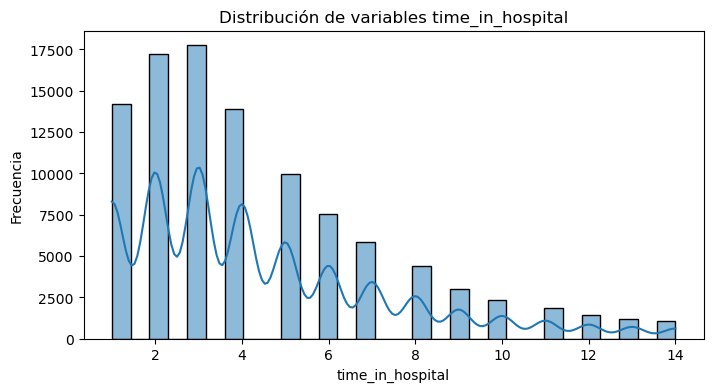

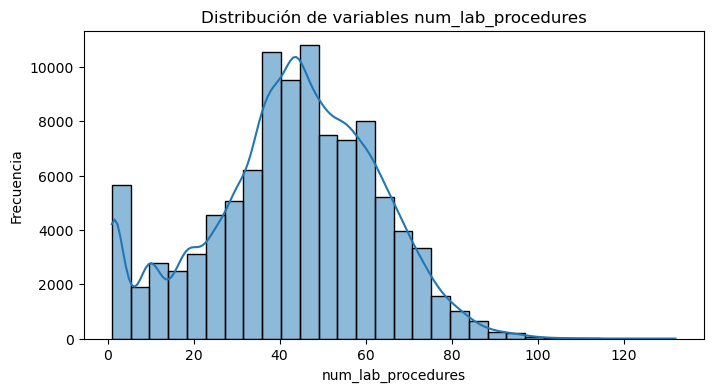

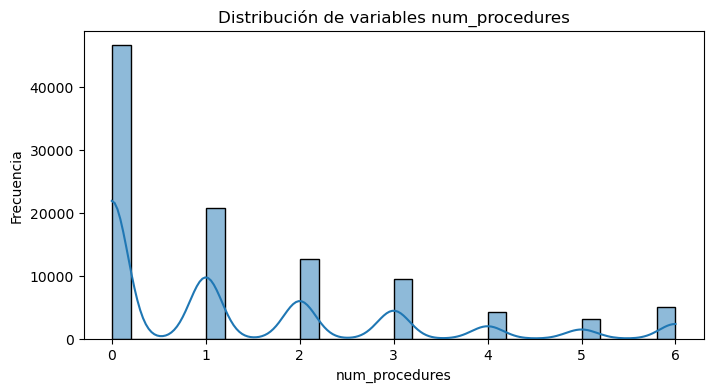

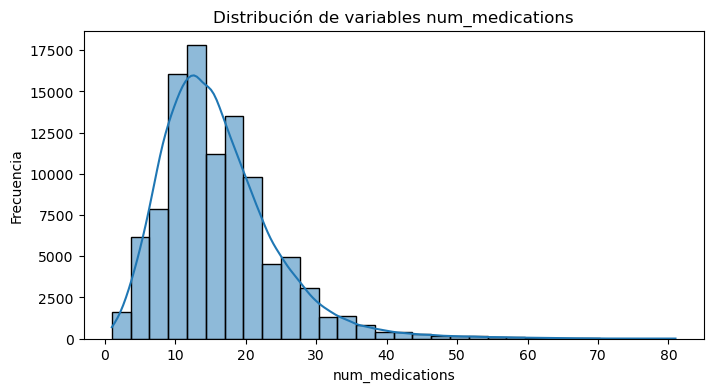

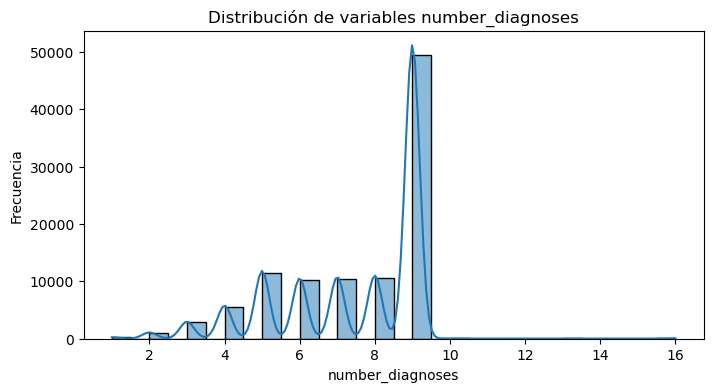

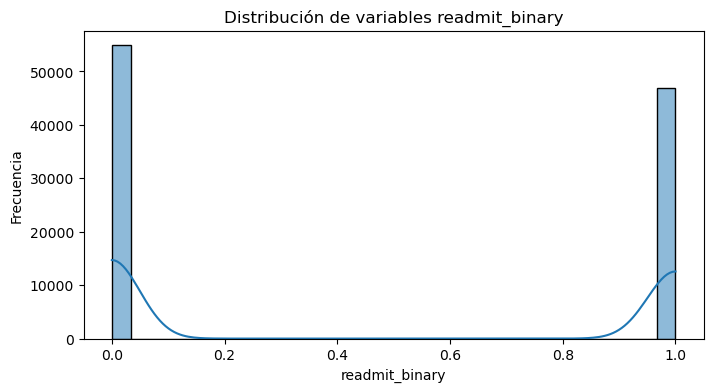

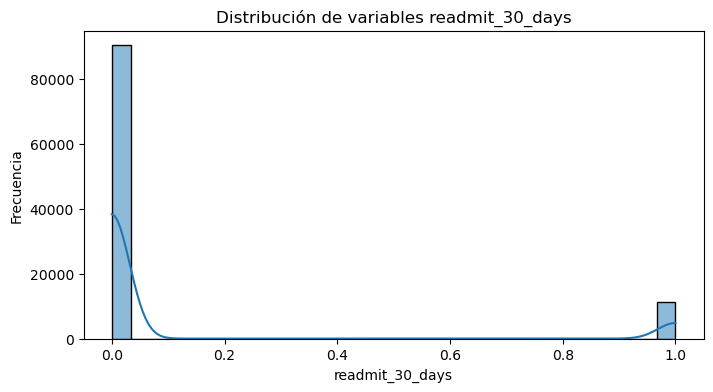

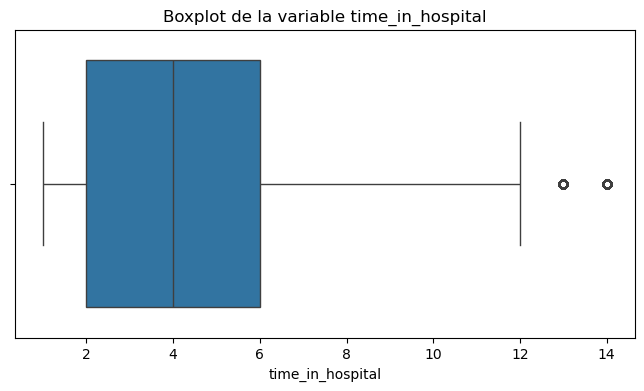

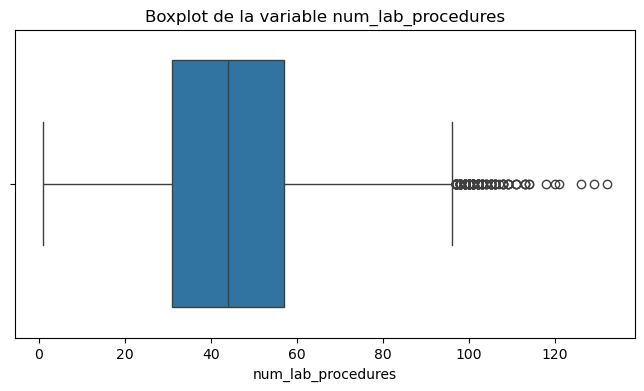

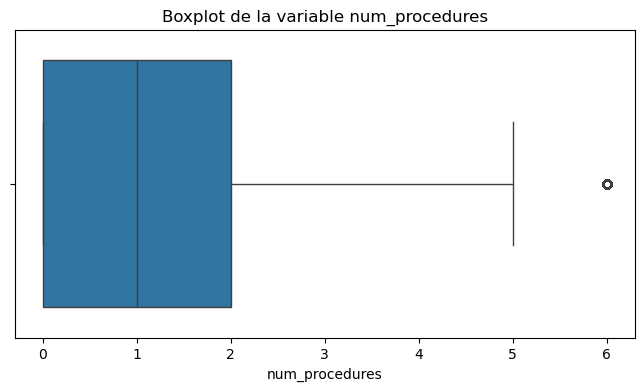

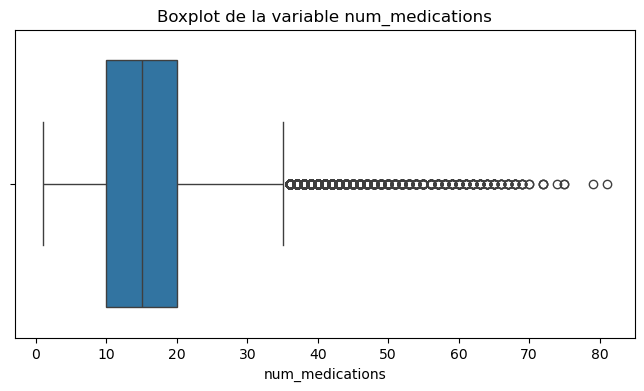

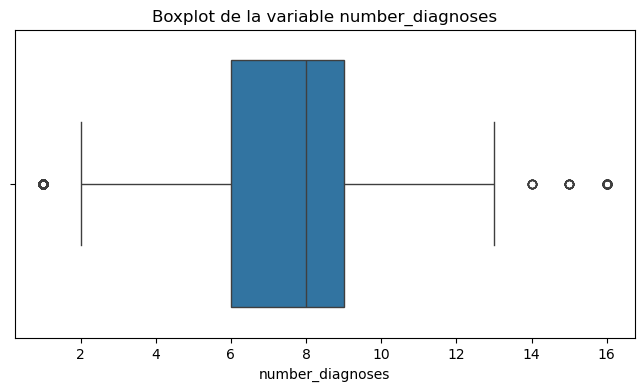

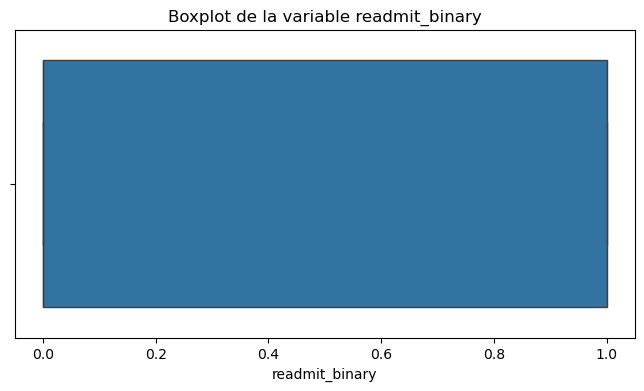

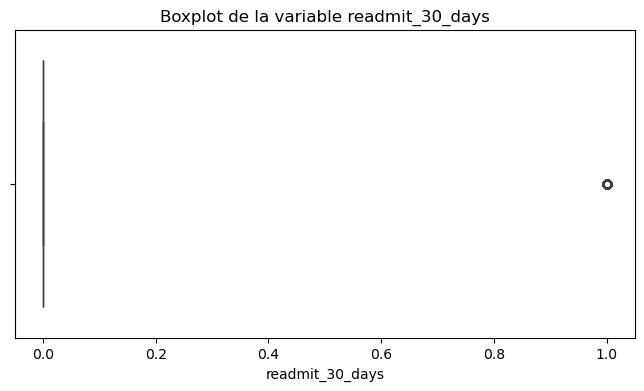

In [87]:
# Identificar variables numéricas
numerical_cols = df.select_dtypes(include=['number']).columns
print("\nVariables numéricas:")
print(df[numerical_cols].describe())

# Crear histogramas
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de variables {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

# Crear boxplots
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de la variable {col}")
    plt.xlabel(col)
    plt.show()

## Análisis Multivariante

Una vez completado el análisis univariante es hora de de hacer el bivariante ¿como se comportan las variables entre ellas? Nos importa especialmente la relación de cada variable con nuestro objetivo `readmit_30_days`.

### Numérica vs Numérica

Realiza primero un estudio de las correlaciones de todas las variables numéricas entre ellas ¿hay alguna altamente correlada que podríamos descartar? Si es así muestra un scatter plot también de ellas para confirmar las sospechas.

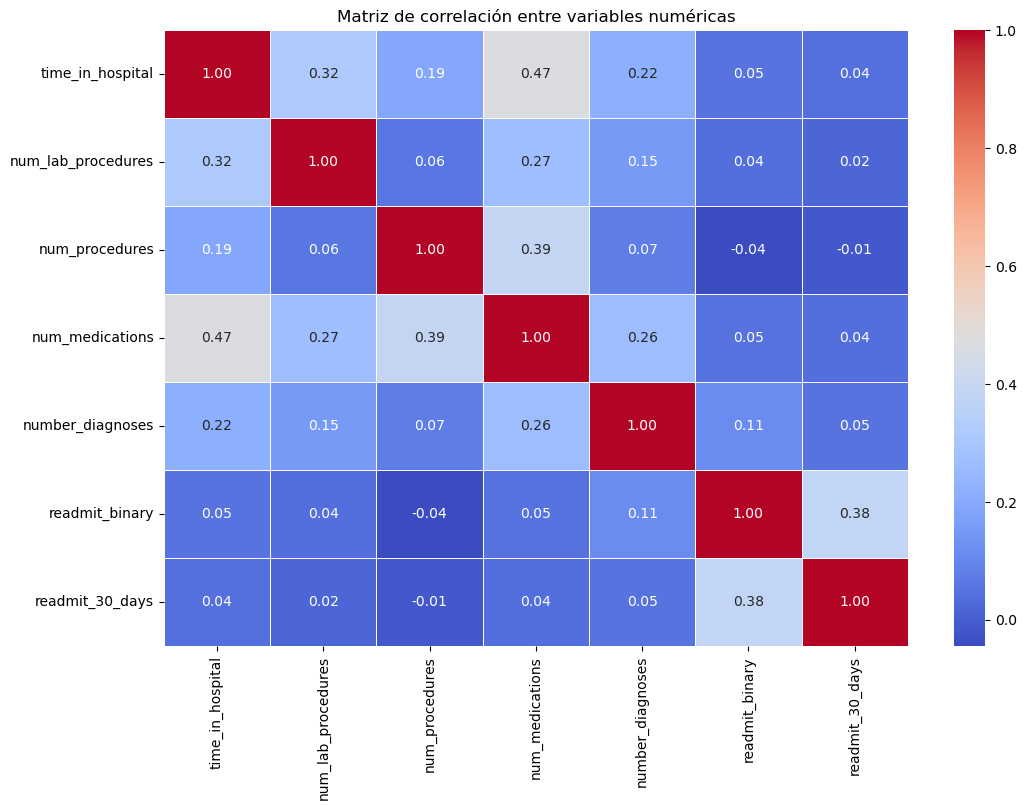


Pares de variables altamente correlacionadas:
Empty DataFrame
Columns: [Var1, Var2, Correlación]
Index: []


In [88]:
# Identificar variables numéricas
numerical_cols = df.select_dtypes(include=['number']).columns

# Calcular la matriz de correlación
correlation_matrix = df[numerical_cols].corr()

# Mostrar un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Identificar pares de variables altamente correlacionadas
highly_correlated_pairs = []
threshold = 0.8
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if col != row and abs(correlation_matrix.loc[row, col]) > threshold:
            highly_correlated_pairs.append((row, col, correlation_matrix.loc[row, col]))

# Crear um DataFrame
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=["Var1", "Var2", "Correlación"])

# Mostrar pares altamente correlacionados
print("\nPares de variables altamente correlacionadas:")
print(highly_correlated_df)

# Si hay pares altamente correlacionados, genere diagramas de dispersión para confirmar la relación
for var1, var2, corr in highly_correlated_pairs:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[var1], y=df[var2], alpha=0.5)
    plt.title(f"Scatter plot entre {var1} y {var2} (Correlación = {corr:.2f})")
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.show()


### Numérica vs Categórica

En esta fase la idea principal es comparar cada una de las variables numéricas contra la variable objetivo, ¿tienen todas algo de relación con la probabilidad de un paciente ser readmitido a los 30 dias? ¿podemos ya descartar alguna?

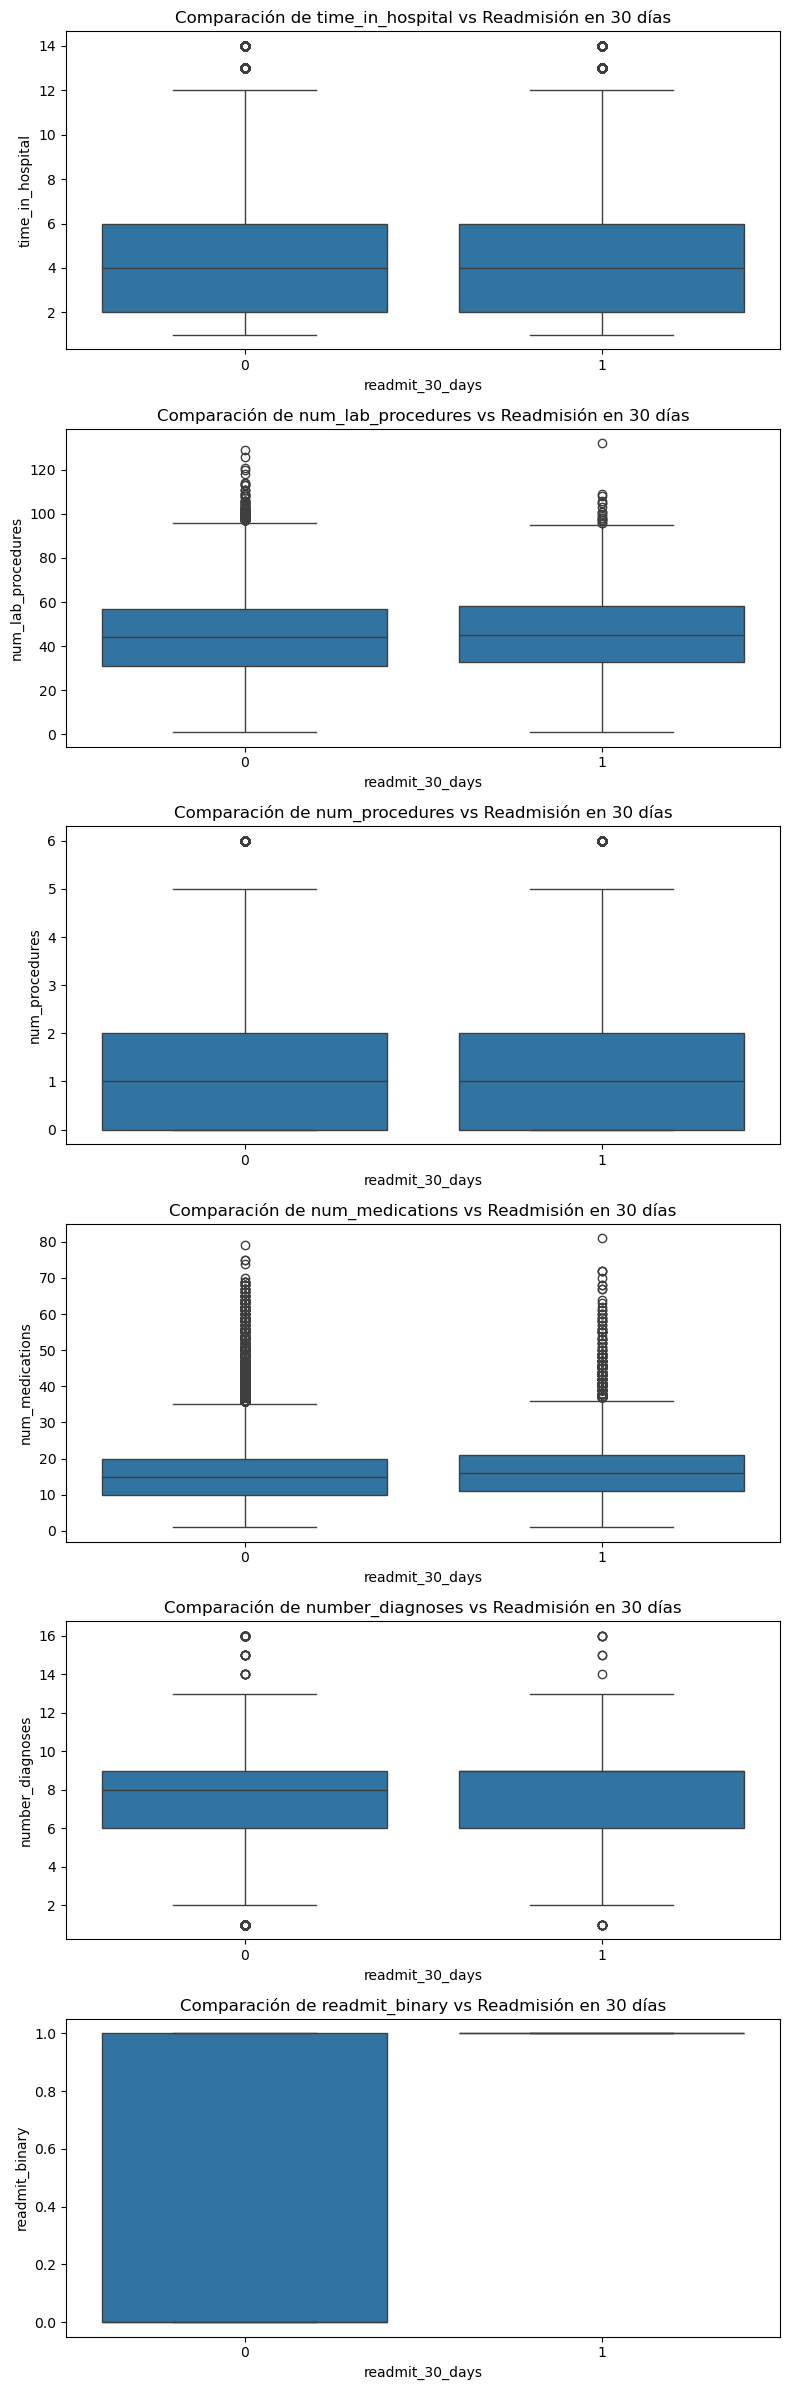

Correlación de variables numéricas con reingreso dentro de los 30 días:
 readmit_30_days       1.000000
readmit_binary        0.383331
number_diagnoses      0.049524
time_in_hospital      0.044199
num_medications       0.038432
num_lab_procedures    0.020364
num_procedures       -0.012227
Name: readmit_30_days, dtype: float64


In [89]:
# Seleccionar variables numéricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Excluir la variable objetivo
numeric_columns.remove('readmit_30_days')

# Crear subtramas
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(8, len(numeric_columns) * 4))

# Comparación de variables numéricas con la tasa de reingreso a 30 días
for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df["readmit_30_days"], y=df[col], ax=axes[i])
    axes[i].set_title(f'Comparación de {col} vs Readmisión en 30 días')
plt.tight_layout()
plt.show()

# Calcular correlación
correlations = df[numeric_columns + ['readmit_30_days']].corr()['readmit_30_days'].sort_values(ascending=False)

print("Correlación de variables numéricas con reingreso dentro de los 30 días:\n", correlations)

### Categórica vs Categórica

Al igual que con las numéricas, observa el comportamiento de cada una de estas variables categóricas con respecto a la variable objetivo. Emplea los test de chi-cuadrado.

In [90]:
# Seleccionar variables categóricas
categorical_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()

# Borrar la variable objetivo
categorical_columns.remove('readmitted')

# Crear un diccionario para almacenar los resultados de la prueba de chi-quadrado
chi2_results = {}

# Realizar la prueba
for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['readmitted'])
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
    chi2_results[col] = p

# Convertir para um DataFrame
chi2_results_df = pd.DataFrame(chi2_results.items(), columns=['Variable', 'P-Value']).sort_values(by='P-Value')

print(chi2_results_df)


                    Variable        P-Value
12             had_emergency   0.000000e+00
13        had_inpatient_days   0.000000e+00
14       had_outpatient_days  1.570426e-270
4        admission_source_id  3.866970e-139
3   discharge_disposition_id  1.458592e-112
7                    insulin  2.126586e-108
5          medical_specialty   1.696985e-96
9                diabetesMed   1.175514e-84
6          primary_diagnosis   7.849688e-57
0                       race   7.379469e-55
8                     change   1.362061e-47
10                  medicare   9.424540e-29
2                        age   9.160858e-27
1                     gender   1.447272e-07
11                  medicaid   2.228843e-01


Enhorabuena! Ya has compleado tu primer Análisis Explolatorio de Datos!!